# Table of Contents

    1. Introduction

    2. Dataset Preparation
    
    3. Exploratory Data Analysis

    4.  KNN Model

        4.1 Hyperparameter Tuning on  KNN Algorithm
        4.2 Building RecSys based on KNN
        4.3 Evaulation of KNN Model 
    

    5. SVD Model

        5.1 Building RecSys based on SVD
        5.2 Evaulation of SVD Model

    6.Conclusion
          

# 1. Introduction

In recent years, Recommender Systems (RecSys) have become an essential tool for companies and websites to personalize their content and improve their user experience. Collaborative filtering techniques are widely used in building RecSys, and two of the most popular methods are K-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD). In this assignment, I will be using the Jester dataset, which contains user ratings for jokes. 

The aim is to build two different RecSys based on KNN and SVD, respectively, to recommend new jokes to users based on their previous ratings. 

While KNN Model will recommend jokes based on the **user-user similarity**, SVD Model will recommend jokes based on **joke-joke similarity**. The KNN technique finds the k most similar users to a given user and uses their ratings to make joke recommendations, while the SVD model factorizes the user-joke matrix into lower-rank matrices to make recommendations based on similar jokes to the user's highest-rated joke.

This assignment is  conducted by Dilay Durukan, a student of the Master's programme Digital Driven Business, as part of the course System Development for Marketing’. This assignment will provide valuable insights into the application of collaborative filtering techniques in building RecSys.

The following main Business question has been formulated: 


 **How can we build  joke recommendations system for providing personalized joke recommendations based on their past ratings?**


To answer this main Business questions the following five sub-questions have been defined:


1. What is the distribution of jokes, users and ratings on our platform?

2. What kind of techniques can be used for recommendation systems for joke recommendations?

3. Which algorithms can be used for identifying similar patterns and recommending jokes based on these patterns?

4. How can we measure the accuracy of  our KNN and SVD models in predicting user ratings for jokes?



# 2. Dataset Preparation

In this section dataset is filtered and rearranged for further purposes

In [1]:
# Importing Necessary libraries 
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

import scipy.stats as stats
import IPython
import glob, os
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import svd
from IPython.display import display
import textwrap

from contextlib import redirect_stdout
from io import StringIO


pd.set_option('display.max_columns', None)

In [2]:
#Reading the datasets with jokes data
df = pd.read_csv("jester_ratings.csv") 
df2 = pd.read_csv("jester_items.csv") 

In [3]:
# Merging datasets according to  "jokeId" 
df = df.merge(right=df2[['jokeId','jokeText']], how='left',on='jokeId')
df.head()

,userId,jokeId,rating,jokeText
0,1,5,0.219,Q.\tWhat's O. J. Simpson's Internet address? \...
1,1,7,-9.281,How many feminists does it take to screw in a ...
2,1,8,-9.281,Q. Did you hear about the dyslexic devil worsh...
3,1,13,-6.781,They asked the Japanese visitor if they have e...
4,1,15,0.875,Q: What did the blind person say when given s...


In [4]:
df.isnull().sum()

userId      0
jokeId      0
rating      0
jokeText    0
dtype: int64

In [5]:
df.shape

(1761439, 4)

In [6]:
df.nunique()

userId      59132
jokeId        140
rating        641
jokeText      140
dtype: int64

In [7]:
(df['rating'].astype(bool)).sum()

1757560

Dataset contains 59132 different users, 140 jokes and 1757560 non-zero ratings ranging from -10 to +10.

In [8]:
df.describe()

,userId,jokeId,rating
count,1.761439e+06,1.761439e+06,1.761439e+06
mean,3.272322e+04,7.071133e+01,1.618602e+00
std,1.828011e+04,4.600790e+01,5.302608e+00
min,1.000000e+00,5.000000e+00,-1.000000e+01
25%,1.720200e+04,2.100000e+01,-2.031000e+00
50%,3.480800e+04,6.900000e+01,2.219000e+00
75%,4.730600e+04,1.120000e+02,5.719000e+00
max,6.397800e+04,1.500000e+02,1.000000e+01


In [9]:
#In order to run the code faster, data is filtered based on some condition on popularity

min_joke = 100   # joke has to have been rated over 100 times
min_user = 50  # user has to have rated at least 50 times

users = df.groupby('userId')['rating'].count()
users = users.loc[users > min_user].index.values
jokes = df.groupby('jokeId')['rating'].count()
jokes = jokes.loc[jokes > min_joke].index.values
df_filtered = df.loc[df.userId.isin(users) & df.jokeId.isin(jokes)]

In [10]:
print('Unfiltered: ', df.shape[0])
print('Filtered: ', df_filtered.shape[0])
print('Kept {}% of data'.format(round(df_filtered.shape[0]/df.shape[0], 2)*100))

Unfiltered:  1761439
Filtered:  947736
Kept 54.0% of data


In [11]:
# sorting df_filtered by  userId and jokeId in ascending order
df_filtered = df_filtered.sort_values(['userId','jokeId',])

# 3. Exploratory Data Analysis

In this step, we go through EDA to understand the data.

In [12]:
#Defining a list of colors that can be used in creating visualizations
colors = sns.color_palette("Paired")

<Figure size 720x720 with 0 Axes>

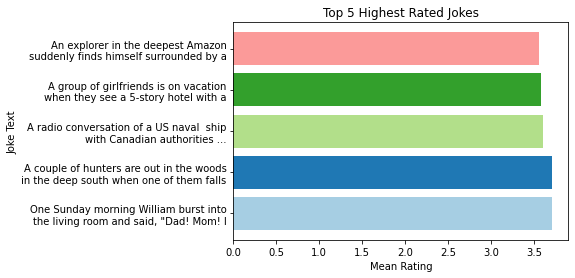

In [13]:
# Top Rated Jokes Plot
plt.figure(figsize=(10,10))

# Group the jokes by ID and compute the mean rating for each joke
joke_ratings = df.groupby(['jokeId', 'jokeText'])['rating'].mean()

# Sort the jokes by mean rating and select the top 10
top_jokes = joke_ratings.sort_values(ascending=False).head(5)

# Extract the joke texts and mean ratings for the top 10 jokes
joke_texts = top_jokes.index.get_level_values('jokeText').tolist()
mean_ratings = top_jokes.values.tolist()

# Wrap long text into two lines
joke_texts = [textwrap.fill(text, width=40).split('\n')[:2] for text in joke_texts]
joke_texts = ['\n'.join(text) for text in joke_texts]
joke_texts

# Plot the top rated jokes
fig, ax = plt.subplots()
ax.barh(joke_texts, mean_ratings, align='center',color=colors)
ax.set_xlabel('Mean Rating')
ax.set_ylabel('Joke Text')
ax.set_title('Top 5 Highest Rated Jokes')

plt.show()

<Figure size 1080x1080 with 0 Axes>

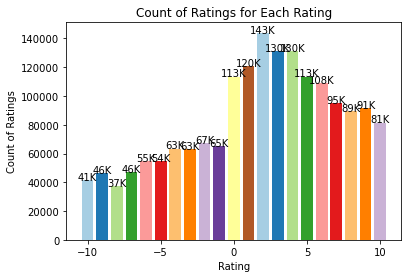

In [14]:
# Count of Ratings for Each Rating Plot
plt.figure(figsize=(15,15))

df['Round_Rating'] = round(df['rating'])

# Group the jokes by rating and count the number of jokes in each rating group
rating_counts = df.groupby('Round_Rating')['jokeId'].count()

# Plot the count of jokes for each rating
fig, ax = plt.subplots()
ax.bar(rating_counts.index, rating_counts.values,color=colors)
ax.set_xlabel('Rating')
ax.set_ylabel('Count of Ratings')
ax.set_title('Count of Ratings for Each Rating')

# Add the count of jokes on top of each bar
for i, v in enumerate(rating_counts.values):
    ax.text(i-10, v + 10, f'{v//1000}K', ha='center')  # format the y-axis tick labels with 'K'

plt.show()

# 4. KNN


In this assignment, a RecSys has been built using the Jester Price dataset, which contains user ratings for jokes. 

The KNN model built in this assignment is based on the **user-user similarity**.

The implemented RecSys uses the KNN algorithm to find the most similar users to a given input user and recommends a joke based on ratings of the similar users.

The KNN algorithm works by comparing the ratings of the input user with those of other users in the dataset, and finding the k most similar users. The similarity between users is determined by the distance between their rating vectors. Once the k most similar users have been identified, the RecSys looks at the jokes rated by these users and recommends the joke with the highest average rating among them.

The system is built on the Jester  dataset, which includes joke IDs, user IDs,joke texts  and joke ratings. By leveraging this data, it is able to provide users with recommendations that are tailored to their preferences and rating history.

In [15]:
# Creating User-Joke Matrix
jokes_user_matrix=df_filtered.pivot(index='userId', columns= 'jokeId',values='rating').fillna(0)

In [16]:
# Split the dataset into train and test sets

jokes_user_train, jokes_user_test = train_test_split(jokes_user_matrix, test_size=0.2, shuffle=False)

train_data=  df_filtered[df_filtered['userId'].isin(jokes_user_train.index.tolist())]
test_data= df_filtered[df_filtered['userId'].isin(jokes_user_test.index.tolist())]

In [17]:
# Preprocess the data into a sparse matrix format
csrtrain = csr_matrix(jokes_user_train.values)

##  4.1 Hyperparameter Tuning on  KNN Algorithm

The goal of hyperparameter tuning is to find the combination of hyperparameters that produces the best performance on the given dataset. The hyperparameters are values that are set before training the model and cannot be learned during training.  In this assignment hyperparameter tuning is done by searching through a range of possible hyperparameters and evaluating the performance of the model using each combination. The evaluation metric used to measure performance is selected as mean of the distances of nearest neighbors aka similar users. If this metric is low it means that the distances are small and neighbors are similar. If this metric is high then distances to  neighbors are higher and users are less similar. The hyperparameters that result in the best performance on the evaluation metric(minimum distance) are selected as the optimal hyperparameters for the model.

In [18]:
#Creating an empty dataframe to store the results of hyperparameter tuning for KNN algorithm
knn_tuning_results = pd.DataFrame(columns=['n_neighbors', 'algorithm', 'metric','mean_distances'])

#Defining the range of hyperparameters to be tuned
n_neighbors= [10, 20, 30]
algorithm= [ 'brute', 'auto']
metric=['cosine', 'euclidean']

#Loop over the combinations of hyperparameters to perform the KNN algorithm with each combination
for i in n_neighbors:
    for j in  algorithm:
        for k in  metric:
            # Create a KNN object with the current hyperparameter combination
            knn = NearestNeighbors(n_neighbors=i,
                           algorithm=j,
                           metric=k)
            # Fit the KNN model with the training data
            knn.fit( csrtrain)
            # Calculate the distances and indices of similar users
            distances, indices = knn.kneighbors(csrtrain, n_neighbors=i)
            # Print the mean of distances to similar users for the current hyperparameter combination
            print('For n=' , i, '  algorithm=', j, '  metric=' , k , '  Mean of distances to similar users= ' , distances.mean())

            # Append the hyperparameter combination and mean distance to the knn_tuning_results dataframe
            knn_tuning_result = {'n_neighbors': i, 'algorithm': j,'metric': k, 'mean_distances': distances.mean()}
            knn_tuning_results = knn_tuning_results.append(knn_tuning_result, ignore_index=True)

For n= 10   algorithm= brute   metric= cosine   Mean of distances to similar users=  0.3621879565060701
For n= 10   algorithm= brute   metric= euclidean   Mean of distances to similar users=  34.56583181612742
For n= 10   algorithm= auto   metric= cosine   Mean of distances to similar users=  0.3621879565060701
For n= 10   algorithm= auto   metric= euclidean   Mean of distances to similar users=  34.56583181612742
For n= 20   algorithm= brute   metric= cosine   Mean of distances to similar users=  0.39912152778212406
For n= 20   algorithm= brute   metric= euclidean   Mean of distances to similar users=  37.32624753630715
For n= 20   algorithm= auto   metric= cosine   Mean of distances to similar users=  0.39912152778212406
For n= 20   algorithm= auto   metric= euclidean   Mean of distances to similar users=  37.32624753630715
For n= 30   algorithm= brute   metric= cosine   Mean of distances to similar users=  0.41658175522933316
For n= 30   algorithm= brute   metric= euclidean   Mean o

In the above, we can see the distances(errors) for each combination of hyperparameters for the KNN model. In the following code, the optimal hyperparameters are selected according to minimum of the distances.

In [19]:
# Finding the index of the row with the minimum mean distance
index_min_value = knn_tuning_results['mean_distances'].idxmin()

#Getting the optimal hyperparameters from the row with the minimum mean distance
best_n_neighbors = knn_tuning_results.iloc[index_min_value, 0]
best_algorithm = knn_tuning_results.iloc[index_min_value,1]
best_metric = knn_tuning_results.iloc[index_min_value, 2]

#Printing the optimal hyperparameters
print('Optimal hyperparameters for the KNN model are n=' , best_n_neighbors, '  algorithm=', best_algorithm, '  metric=' , best_metric )


Optimal hyperparameters for the KNN model are n= 10   algorithm= brute   metric= cosine



After performing hyperparameter tuning on a KNN algorithm, the optimal hyperparameters are determined based on their ability to minimize the error of the model. Since the optimal hyperparameters are determined now, they can be used to train the KNN model with the goal of minimizing the error.

##  4.2 Building RecSys based on KNN

In [20]:
# Create a new NearestNeighbors object with the best hyperparameters found during tuning
knn = NearestNeighbors(n_neighbors=best_n_neighbors,
                           algorithm=best_algorithm,
                           metric=best_metric)

# Fitting the KNN model on the training data
knn.fit(csrtrain)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

#### - Creating a function that finds similar users to a given user

This function takes an input_user_index and neighbor_count as inputs. It calculates the k nearest neighbors of the input user based on their interaction history with jokes using the KNN model trained earlier. Then, it prints the most similar users to the input user based on the calculated distances. Finally, it creates a list of similar users based on their indices in the training data and returns it.

In [21]:
def get_similar_users(input_user_index, neighbor_count=best_n_neighbors+1):
    
    # Finding the k nearest neighbors of the input user 
    distances, indices = knn.kneighbors(jokes_user_train.iloc[input_user_index,:].values.reshape(1,-1), n_neighbors=neighbor_count)
  
   
    # Creating a list of similar users 

    similaruser_ids=[]

    # Printing the most similar users to the input user based on the calculated distances
    for i in range(0,len(distances.flatten())):
        if i==0:            #Most similar user to input user is itself with zero distance. So not printing the input user 
            print('Similar Users for User',jokes_user_train.index[indices.flatten()[i]],' \n')
        else:
            print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indices.flatten()[i]]),' with distance of ',str(distances.flatten()[i]) )
            
            # Appending the similar users to the list               
            similaruser_ids.append(jokes_user_train.index[indices.flatten()[i]])



    return similaruser_ids


    # indices are the index of the similar users in the jokes_user_train dataframe
    # jokes_user_train.index[indices.flatten()[1]] are the user_ids of the similar users
    

#### - Creating a function for finding the joke with the highest average rating

This function takes a pandas DataFrame object 'JokesfromSimilarUsers' as input, which contains a list of jokes and their average rating by similar users. 
The code first converts the 'jokeId', 'avg_rating_by_similar_users', and 'jokeText' columns of the DataFrame into lists using the 'tolist()' method. 
Then, it initializes variables to keep track of the maximum rating and the recommended joke. 
The code loops through the lists to find the joke with the highest rating. For each joke, the code checks whether its rating is greater than the current maximum rating (maxrating). If so, the joke's text (textlist[i]) is stored in the recommended_joke variable and its rating is stored in the maxrating variable. Finally, the function returns the recommended joke with the highest rating.

In [22]:
def get_Jokes_with_Highhest_Rating_from_Similar_Users(JokesfromSimilarUsers):

    # Converting jokeId, jokeText and avg_rating_by_similar_users columns to lists
    
    jokeidlist=JokesfromSimilarUsers["jokeId"].tolist()
    ratelist= JokesfromSimilarUsers["avg_rating_by_similar_users"].tolist()
    textlist= JokesfromSimilarUsers["jokeText"].tolist()

    # Initialize variables to keep track of maximum rating and recommended joke
    maxrating=0
    recommended_joke = None

    #Loop through the lists to find the joke with the highest rating
    for i in range(0,len(jokeidlist)):
        if (ratelist[i]> maxrating):
            recommended_joke=textlist[i]
            maxrating=ratelist[i]

    # Returning the recommended joke with the highest rating            
    return recommended_joke

### - Creating a function that recommends a Joke for the User

This function get_KNN_recommandations_for_user takes an input user ID and neighbor count as inputs. It first finds the index of the input user in the train_data dataframe, and then gets the similar users using the get_similar_users function created earlier.

Then, it filters out the data for the similar users and calculates the average rating for each joke by these users. It creates a new dataframe JokesfromSimilarUsers which contains unique jokes with their corresponding joke ID, joke text, and average rating by similar users.

Next, it removes the jokes that the input user has already rated from the JokesfromSimilarUsers dataframe.

If all the jokes rated by similar users are also watched by the input user, then the function recursively calls itself with an increased neighbor user count to find more dissimilar users to generate recommendations.


After this, it calls the function get_Jokes_with_Highhest_Rating_from_Similar_Users to get the joke with the highest average rating by similar users from the filtered JokesfromSimilarUsers dataframe.

Then, it finds the rating of this joke by similar users and its general rating in the entire dataset, and prints these along with the recommended joke for the input user.





In [23]:
def get_KNN_recommandations_for_user(input_user, neighbor_count=best_n_neighbors+1):
   
    #Getting the index of given input user in train data
    user_ids = train_data['userId'].unique()
    user_ids.sort()
    user_ids=user_ids.tolist()
    input_user_index = user_ids.index(input_user)
   
    
    #Getting similar users to given input user
    similaruser=None
    similaruser=get_similar_users(input_user_index,neighbor_count)
    
    #Filtering the data to only include the rows of similar users
    similar_user_data=None
    similar_user_data = train_data[train_data["userId"].isin(similaruser)]

    #Computing the Average Rating of Jokes among the similar users 
    similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')


    # Getting jokes rated by similar users and   excluding jokes that already rated by input_user
    JokesfromSimilarUsers=None
    JokesfromSimilarUsers= similar_user_data[["jokeId",'jokeText','avg_rating_by_similar_users']].drop_duplicates(subset=['jokeId'])
    JokesRatedBySelectedUser=train_data[(train_data['userId'] == input_user)]['jokeText'].tolist()
    JokesfromSimilarUsers = JokesfromSimilarUsers[~JokesfromSimilarUsers['jokeText'].isin(JokesRatedBySelectedUser)]

    # If all the jokes  rated by  similar users are also  rated by the selected user, call the function again with increased  neighbor user count
    if (JokesfromSimilarUsers.empty):
        print('All the jokes rated  by', (neighbor_count-1),' similar users are all  rated by the selected user. Similar user count  is increased by 5 to ', neighbor_count+5)
        return get_KNN_recommandations_for_user(input_user, neighbor_count+5)


    # Getting the recommended joke with the highest average rating among similar user
    recommended_joke=None
    recommended_joke = get_Jokes_with_Highhest_Rating_from_Similar_Users(JokesfromSimilarUsers)


    # Assigning rating values to the  variables that desired to print
        # get average rating for recommended joke among similar users
    RatingbySimilarUsers=JokesfromSimilarUsers[(JokesfromSimilarUsers['jokeText'] == recommended_joke)]['avg_rating_by_similar_users'].iloc[0]
        # get general rating for recommended joke in training data
    GeneralRating=round(train_data[(train_data['jokeText'] == recommended_joke)].groupby('jokeId')['rating'].transform('mean').iloc[0])
    
    # Printing the recommendation joke with ratings
    print('\n \n For User ',input_user, 'recommended joke is: \n', recommended_joke,' \n', ' with Rating by Similar Users: ' , RatingbySimilarUsers,' \n', ' with General Rating: ' , GeneralRating )
 
     

#### - Getting Joke Recommendation  to Random User based on KNN


This code selects a random user id from the list of unique user ids in the train_data dataframe using the np.random.choice() function. The get_KNN_recommandations_for_user() function is then called with this randomly selected user id as the input to generate a joke recommendation for the selected user using the KNN algorithm.

The get_KNN_recommandations_for_user() function first finds the index of the input user id in the user_ids list using the index() method. Then, it calls the get_similar_users() function to find a list of similar users to the input user based on their rating patterns. The function then filters out the jokes already rated by the input user and calculates the average rating of the remaining jokes by the similar users. It selects the joke with the highest rating and returns its text as the recommended joke for the input user.

Finally, the function also prints the rating of the recommended joke by the similar users and the general rating of the same joke in the entire dataset. This code allows for easy testing of the recommendation algorithm on different users.

In [24]:
# Getting the  list of unique user IDs in training data
user_ids = train_data['userId'].unique()
user_ids.sort()
user_ids=user_ids.tolist()

#Getting the Joke Recommandation based on KNN to a Random User from the list of User IDs 
get_KNN_recommandations_for_user(np.random.choice(user_ids))  #Input user id can be changed to any user id available in the dataset

Similar Users for User 10184  

Most Similar User 1 : User_Id 4032  with distance of  0.33853756848368655
Most Similar User 2 : User_Id 23871  with distance of  0.3755648100938499
Most Similar User 3 : User_Id 38585  with distance of  0.3909016040851172
Most Similar User 4 : User_Id 19415  with distance of  0.3955097658475413
Most Similar User 5 : User_Id 30117  with distance of  0.3999158570721685
Most Similar User 6 : User_Id 44858  with distance of  0.4085140543674889
Most Similar User 7 : User_Id 7610  with distance of  0.4161437380676819
Most Similar User 8 : User_Id 48869  with distance of  0.4189233222485169
Most Similar User 9 : User_Id 39751  with distance of  0.42324402515326787
Most Similar User 10 : User_Id 3786  with distance of  0.4307891349693873

 
 For User  10184 recommended joke is: 
 A group of girlfriends is on vacation when they see a 5-story hotel with a sign that reads: "For Women Only." Since they are without their boyfriends and husbands, they decide to go in.

c:\Users\yigit\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### - Example on One User to Show the Each Interior Step

In [25]:
# Getting the  list of unique user IDs in training data
user_ids = train_data['userId'].unique()
user_ids.sort()
user_ids=user_ids.tolist()

#Getting the Joke Recommandation based on KNN to a Random User from the list of User IDs 
#get_KNN_recommandations_for_user(35560)
input_user_index = user_ids.index(35560)
print('\n Input users index is ', input_user_index)
neighbor_count=10
# Finding the k nearest neighbors of the input user 
distances, indices = knn.kneighbors(jokes_user_train.iloc[input_user_index,:].values.reshape(1,-1), n_neighbors=neighbor_count+1)
print(' \n distances are ')
print(distances.flatten())

print(' \n indices are')
print(indices.flatten())

similaruser_ids=[]
    # Printing the most similar users to the input user based on the calculated distances
for i in range(0,len(distances.flatten())):
    if i==0:            #Most similar user to input user is itself with zero distance. So not printing the input user 
        print(' \n Similar Users for User',jokes_user_train.index[indices.flatten()[i]],' \n')
    else:
        print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indices.flatten()[i]]),' with distance of ',str(distances.flatten()[i]) )
        similaruser_ids.append(jokes_user_train.index[indices.flatten()[i]])

print(' \n similaruserid list ')

print(similaruser_ids)




 #Filtering the data to only include the rows of similar users
similar_user_data=None
similar_user_data = train_data[train_data["userId"].isin(similaruser_ids)]
#Computing the Average Rating of Jokes among the similar users 
similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')
print(' \n similar_user_data ')
print(similar_user_data)

# Getting jokes rated by similar users and   excluding jokes that already rated by input_user
JokesfromSimilarUsers=None
JokesfromSimilarUsers= similar_user_data[["jokeId",'jokeText','avg_rating_by_similar_users']].drop_duplicates(subset=['jokeId'])

JokesRatedBySelectedUser=train_data[(train_data['userId'] == 35560)]['jokeText'].tolist()
JokesfromSimilarUsers = JokesfromSimilarUsers[~JokesfromSimilarUsers['jokeText'].isin(JokesRatedBySelectedUser)]
print(' \n JokesfromSimilarUsers ecluding jokes of user ')
print(JokesfromSimilarUsers)

# Getting the recommended joke with the highest average rating among similar user
recommended_joke=None
recommended_joke = get_Jokes_with_Highhest_Rating_from_Similar_Users(JokesfromSimilarUsers)
RatingbySimilarUsers=JokesfromSimilarUsers[(JokesfromSimilarUsers['jokeText'] == recommended_joke)]['avg_rating_by_similar_users'].iloc[0]

print(' \n recommended_joke ')
print(recommended_joke, ' with Rating by Similar Users: ' , RatingbySimilarUsers)

    


 Input users index is  5059
 
 distances are 
[3.33066907e-16 3.95359561e-01 4.34080177e-01 4.37761506e-01
 4.73041320e-01 4.76263873e-01 4.79189974e-01 4.80054261e-01
 4.86133902e-01 4.86884173e-01 4.89175830e-01]
 
 indices are
[5059 2418 3732 2404 8043 6381 4110 2504 6439 7770 6621]
 
 Similar Users for User 35560  

Most Similar User 1 : User_Id 16481  with distance of  0.39535956062392763
Most Similar User 2 : User_Id 29387  with distance of  0.43408017655388254
Most Similar User 3 : User_Id 16335  with distance of  0.4377615061779373
Most Similar User 4 : User_Id 48727  with distance of  0.4730413198706176
Most Similar User 5 : User_Id 41091  with distance of  0.47626387279734816
Most Similar User 6 : User_Id 31271  with distance of  0.47918997439820976
Most Similar User 7 : User_Id 17166  with distance of  0.48005426069764656
Most Similar User 8 : User_Id 41332  with distance of  0.4861339017089066
Most Similar User 9 : User_Id 47490  with distance of  0.4868841725748124
Most S

c:\Users\yigit\Miniconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##  4.2 Evaluation of KNN Model 

To evaluate the performance of the KNN model and to measure its effectiveness in generating accurate recommendations, a comparison will be made between the predicted ratings and the actual ratings for a predefined set of users and jokes.

 The objective is to identify the users for whom the model recommends a joke that they have already rated. Predicted ratings will be the average ranking of jokes among the similar users. This  allows  to calculate the Root Mean Squared Error (RMSE) between the user's actual rating and the predicted rating for the recommended joke.

By calculating the RMSE, it is possible to determine how closely the predicted ratings match the actual ratings. A lower RMSE indicates better accuracy and suggests that the model is doing a good job of recommending jokes that the user would rate highly. This information can be used to fine-tune the model to further improve its accuracy and to provide better recommendations to users. 

### Creating the same recommendation  system but this time jokes rated by the input user are not excluded.

Functions created earlier are excluding the jokes rated by user. To identify the users for whom the model recommends a joke that they have already rated' similar functions need to be created without excluding the jokes rated by user. 

#### - Creating a function that finds similar users to a given Test user

This function takes an input_test_user and neighbor_count as inputs. It first creates a row of the test user's interaction history with jokes and then finds the k nearest neighbors of the test user based on their interaction history with jokes using the KNN model trained earlier. It then prints the most similar users to the test user based on the calculated distances. Finally, it creates a list of similar user ids in the training data and returns it.

In [26]:
def get_similar_users_for_testing(input_test_user, neighbor_count=best_n_neighbors+1):
    #Since it is for testing purposes I commented out the print statements
    
    test_user_row = jokes_user_test.loc[input_test_user].values.reshape(1, -1)
    distances_test, indices_test = knn.kneighbors(test_user_row, n_neighbors=neighbor_count)


    similaruser2=[]


    # print('\n Similar Users for User', input_test_user,' \n')
  
    # Printing the most similar users to the input user based on the calculated distances
    for i in range(1,len(distances_test.flatten())):
    
        #print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indices_test.flatten()[i]]),' with distance of ',str(distances_test.flatten()[i]) )
        #Creating list for the similar users
        similaruser2.append(jokes_user_train.index[indices_test.flatten()[i]])

    
    return similaruser2
    

#### - Creating a function that gets the highest rated

This function is the same with training part

In [27]:
def get_Jokes_with_Highhest_Rating_from_Similar_Users_for_testing(JokesfromSimilarUsers):

    # Converting jokeId, jokeText and avg_rating_by_similar_users columns to lists
    
    jokeidlist=JokesfromSimilarUsers["jokeId"].tolist()
    ratelist= JokesfromSimilarUsers["avg_rating_by_similar_users"].tolist()
    textlist= JokesfromSimilarUsers["jokeText"].tolist()

    # Initialize variables to keep track of maximum rating and recommended joke
    maxrating=0
    recommended_joke2 = None

    #Loop through the lists to find the joke with the highest rating
    for i in range(0,len(jokeidlist)):
        if (ratelist[i]> maxrating):
            recommended_joke2=textlist[i]
            maxrating=ratelist[i]

    # Returning the recommended joke with the highest rating            
    return recommended_joke2

#### - Creating a function that gets joke recommendation for test users

In [28]:
def get_KNN_recommandations_for_user_for_testing(input_test_user, neighbor_count=best_n_neighbors+1):
   

    #Getting similar users to given input user
    similaruser=None
    similaruser=get_similar_users_for_testing(input_test_user,neighbor_count)

    #Filtering the data to only include the rows of similar users
    similar_user_data=None
    similar_user_data = train_data[train_data["userId"].isin(similaruser)]

    #Computing the Average Rating of Jokes among the similar users 
    similar_user_data['avg_rating_by_similar_users']  = similar_user_data.groupby('jokeId')['rating'].transform('mean')


    # Getting jokes rated by similar users
    JokesfromSimilarUsers=None
    JokesfromSimilarUsers= similar_user_data[["jokeId",'jokeText','avg_rating_by_similar_users']].drop_duplicates(subset=['jokeId'])


    # Getting the recommended joke with the highest average rating among similar user
    recommended_joke2=None
    recommended_joke2 = get_Jokes_with_Highhest_Rating_from_Similar_Users_for_testing(JokesfromSimilarUsers)


    # Assigning rating values to the  variables that desired to print
        # get average rating for recommended joke among similar users
    RatingbySimilarUsers=JokesfromSimilarUsers[(JokesfromSimilarUsers['jokeText'] == recommended_joke2)]['avg_rating_by_similar_users'].iloc[0]

    return recommended_joke2,RatingbySimilarUsers  

     

#### -Testing KNN Model Performance

In [29]:
#APPLYING TESTS
test_matrix = pd.DataFrame(columns=['userid', 'joketext', 'predicted_rating','actual_rating'])

#Getting Joke Recommandation to Every User in Test Data based on KNN

user_ids_test = test_data['userId'].unique()
user_ids_test.sort()
user_ids_test=user_ids_test.tolist()

for test_user_id in user_ids_test:
    with redirect_stdout(StringIO()): #Not printing the output of the inner steps
    
        try:

            test_user_row = jokes_user_test.loc[test_user_id].values.reshape(1, -1)
            recommended_joke=None
            RatingbySimilarUsers  =None
            recommended_joke, RatingbySimilarUsers  = get_KNN_recommandations_for_user_for_testing(test_user_id)

            # Check if the actual rating for the recommended joke is non-zero
            if ((test_data['userId'] == test_user_id) & (test_data['jokeText'] == recommended_joke)).any() and  test_data[(test_data['userId'] == test_user_id) & (test_data['jokeText'] == recommended_joke)]['rating'].values[0] != 0:
                test_row = {'userid': test_user_id, 'joketext': recommended_joke,'predicted_rating': RatingbySimilarUsers, 'actual_rating': test_data[(test_data['userId'] == test_user_id) &(test_data['jokeText'] == recommended_joke)]['rating'].iloc[0]}
                test_matrix = test_matrix.append(test_row, ignore_index=True)
        
                # print('recommended joke  is  ON THE LIST for user', test_user_id )

             #else:
                # print('recommended joke is not on the list for user', test_user_id)
        except:
        # If there is an error for a particular user, print an error message and continue to the next user
            print("Error in user id", test_user_id)
            continue    

# calculate the RMSE between the predicted ratings and actual ratings

y_test = test_matrix['actual_rating']
y_pred =test_matrix['predicted_rating']

print('\n RMSE is calculated according to following matrix: \n',test_matrix.head())
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("\n % ", ((test_matrix.shape[0]/len(user_ids_test))*100), ' of the test users are recommended a joke that they are already rated')

print("\n RMSE:", rmse)
 

c:\Users\yigit\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\Users\yigit\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
c:\Users\yigit\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume


 RMSE is calculated according to following matrix: 
   userid                                           joketext  predicted_rating  \
0  49941  A little boy goes to his dad and asks, "What i...          7.711889   
1  49963  Q: What is the difference between Mechanical E...          8.972100   
2  49985  A radio conversation of a US naval \nship with...          3.453100   
3  49987  A group of  managers were given the assignment...          8.722000   
4  49993  A little girl asked her father, "Daddy? Do all...          8.578100   

   actual_rating  
0          6.688  
1          7.406  
2          4.719  
3          7.531  
4          7.656  

 %  75.86206896551724  of the test users are recommended a joke that they are already rated

 RMSE: 3.5014182641841587


#### - An Example on One User

In [30]:
# APPLYING TO ONE TEST USER EXAMPLE
input_test_user_id= 49946
test_user_row = jokes_user_test.loc[49941].values.reshape(1, -1)
distancestest, indicestest = knn.kneighbors(test_user_row, n_neighbors=best_n_neighbors+1)


print(' \n distances are ')
print(distancestest.flatten())
print(distancestest.flatten()[1])

print(' \n indices are')

print(indicestest.flatten())
print(indicestest.flatten()[1])



#print('\n Similar Users for User', input_test_user_id,' \n')
  
 # Printing the most similar users to the input user based on the calculated distances
for i in range(1,len(distancestest.flatten())):
    
    #print( 'Most Similar User',i,': User_Id ' +  str(jokes_user_train.index[indicestest.flatten()[i]]),' with distance of ',str(distancestest.flatten()[i]) )



    #Creating list for the similar users
    similaruser2=[]
    for i in range(0,len(distances.flatten())):
        similaruser2.append(jokes_user_train.index[indicestest.flatten()[i]])
        
print(test_user_row)
jokes_user_train.loc[33640].values.reshape(1, -1)

from scipy.spatial.distance import cosine
a=jokes_user_test.loc[49941].values.reshape(1, -1)
cosine(a, jokes_user_train.loc[33640].values.reshape(1, -1))

 
 distances are 
[0.48984949 0.49014196 0.49249364 0.49484695 0.50894253 0.50958816
 0.51459717 0.51883234 0.51938623 0.52061704 0.52124159]
0.4901419609108971
 
 indices are
[1387 4635 8039 6144 5730 7061  571 1216 6433 1084 2243]
4635
[[ 0.    -8.125 -7.844 -8.062 -8.281  7.406 -4.344 -5.594  5.625  0.
  -3.25  -7.031 -5.812 -2.906 -6.719  0.031  0.     6.25  -1.938 -2.375
   0.     5.812 -2.688  6.875  9.812  7.938 -8.281  4.719 -2.812  4.719
  -6.688 -2.344  0.    -2.156  6.75   4.531 -2.969 -2.719  2.719 -2.312
   0.     0.     7.125 -3.906 -7.875  6.781 -3.062  4.938  2.469 -3.625
   0.     2.812  0.094 -3.625 -4.188  7.594 -8.062 -1.031  2.062  5.406
  -6.094  8.344  0.    -1.812  5.5    1.031  3.156 -1.156 -6.625  0.
   4.312  2.938  7.    -2.688 -6.5   -4.031  3.25  -2.469  0.406  1.344
  -5.531  5.656  6.094 -1.781 -2.875  7.719 -3.375  3.406 -6.625  0.
  -6.438  0.062  5.469  3.781  6.625  6.344 -3.094  2.375  7.938 -2.688
   4.938 -2.438  1.656  5.312  6.406  0.     6.781 

0.490141960910897

# 5. SVD

SVD is a widely used matrix factorization technique in machine learning that can be used for various tasks, including image compression, data compression, and recommender systems. It decomposes a matrix into three separate matrices, each representing the latent factors of the original matrix. 

In this assignment, a RecSys has been built using the Jester Price dataset, which contains user ratings for jokes. The implemented RecSys uses the SVD algorithm to identify similar jokes based on a user's highest rated joke and recommend them to the user.

The SVD algorithm works by decomposing the user-joke matrix into three separate matrices, each representing the latent factors of the original matrix. This factorization allows us to identify similar jokes based on the users' ratings, rather than just their content. To begin, the recommendation system takes the user ID as input and identifies the highest rated joke by that user. The SVD model is then applied to identify similar jokes to the user's highest rated joke, and these similar jokes are recommended to the user.

This implementation offers a powerful and accurate approach to recommend jokes to users based on their preferences, as identified by the SVD algorithm. The RecSys has the potential to enhance user engagement and satisfaction by providing personalized recommendations that match their sense of humor. The algorithm can also be further improved by incorporating other features such as the text content of jokes, to provide even more accurate recommendations.

##  5.1 Building RecSys based on SVD

### - Singular value decomposition


In [31]:
# Singular value decomposition

u, s, vt = svd(jokes_user_train, full_matrices=False)

### - Creating a function for calculating cosine similarity


Cosine similarity is often used for recommendation systems because it is a measure of similarity between two vectors that is particularly well-suited for high-dimensional data, such as the feature vectors that are commonly used to represent jokes. In a joke  recommendation system, each joke can be represented as a vector of features. Cosine similarity measures the cosine of the angle between two vectors, which can be interpreted as a measure of their similarity in direction. In the context of a joke recommendation system, the direction of a vector represents the combination of features that describe a joke. If two jokes have similar feature vectors, their cosine similarity will be high, indicating that they are similar in terms of the features that they share.

In [32]:
# Creating a function for calculating cosine similarity
def cosine_similarity(v,u):
    # Calculate the dot product of v and u, and divide by the product of their magnitudes
    return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))  #The @ symbol is used to calculate the dot product of v and u 

### - Creating a Function for Finding Similar Jokes on SVD Model

This function calculates the cosine similarity between the given joke and all other jokes in a user-item matrix using a Singular Value Decomposition (SVD) model. Then, it returns a list of the indices of the top similar jokes to the given joke_index that a user with userId might enjoy, excluding the ones already rated by the user, and limited to the specified number of jokes.

The input parameters for the function are
userId: the ID of the user for whom we want to find similar jokes
joke_index: the index of the joke for which we want to find similar jokes
num_jokes: the maximum number of similar jokes to return (default is 1)

First, the function calculates the cosine similarity between the joke_index joke and all other jokes in the dataset, using the transpose of the right singular vectors of the SVD model. The resulting similarities are stored in a list.

Next, the function obtains a list of jokes already rated (or "heard") by the user with the specified userId.

Then, the function sorts the list of similarities in descending order and iterates over the indices of the corresponding jokes. For each joke, it checks if it has not already been rated by the user and adds it to a list of similar jokes until num_jokes jokes have been added.

Finally, the function returns a list of the indices of the similar jokes.

In [33]:
def get_similar_jokes(userId, joke_id, num_jokes=1):

    
    # Convert joke ID to index
    joke_ids_list = train_data['jokeId'].unique().tolist()
    joke_index = joke_ids_list.index(joke_id)

    # Calculate the cosine similarity between the given joke and all other jokes in the user-item matrix
    similarities = [cosine_similarity(vt[joke_index], vt[i]) for i in range(vt.shape[0])]

    # Getting the list of the jokes rated (aka heard) by the user  
    user_ratedjokes = train_data[(train_data['userId'] == userId)]['jokeId'].tolist()

  # Get the indices of the top similar jokes, excluding jokes already rated by the user
    similar_jokes_ids = []
    for i in np.argsort(similarities)[::-1]:
        joke_ids = i+1  #Since  (jokes_user_train.columns)[0]=joke id 1
        if  joke_ids not in user_ratedjokes: # excluding jokes already rated by the user
            similar_jokes_ids.append(joke_ids)
        if len(similar_jokes_ids) == num_jokes:
            break 
    return similar_jokes_ids

#### - Creating a function that recommends a joke for the User

The get_SVD_recommandations_for_user function is designed to generate recommendations for a given user based on  previous joke ratings. The default value for recommended joke count is set to 1.

It first finds the highest rated joke by the given user. To do this, it sorts the user ratings in descending order and retrieves the joke ID  and title of the highest rated joke  from the first row.

Then, the function calls the get_similar_jokes() function with the user ID and highest rated joke ID as input parameters to find similar jokes.  This function uses matrix factorization and cosine similarity to find other jokes that are similar to the highest rated joke, which are likely to appeal to the user.

The function then prints the top (num_jokes) similar jokes for the user to the console using a for loop.


In [34]:
def get_SVD_recommandations_for_user(userId, num_jokes=1):

    # Find the highest rated joke by the given user
        # Get all ratings made by the given user
    user_ratings = train_data[train_data['userId'] == userId]
        # Sort the ratings in descending order to find the highest rated joke
    user_ratings_sorted = user_ratings.sort_values(['rating'], ascending=[False])
        # Get the joke ID of the highest rated joke by the user
    highest_rated_joke_id = user_ratings_sorted.iloc[0]['jokeId']
        # Get the title of the highest rated joke
    highest_rated_joke_title = train_data[train_data['jokeId'] == highest_rated_joke_id]['jokeText'].values[0]
        # Print the title of the highest rated joke by the user
    print("Highest rated  joke by user", userId, "is:", highest_rated_joke_title)
    
    # Get similar jokes based on the highest rated joke
    similar_jokes=None
    similar_jokes= get_similar_jokes(userId,highest_rated_joke_id,num_jokes)

    
    # Print the top 'num_jokes'  similar jokes for the user
    print("Top", num_jokes, "similar jokes for user ", userId , ': ')
    for i, jokeId in enumerate(similar_jokes):
        print(i+1, ".", similar_jokes[i], ' ',  train_data[train_data['jokeId'] == similar_jokes[i]]['jokeText'].values[0])

#### - Getting Joke Recommandation to Random User based on SVD


This code selects a random user id from the list of unique user ids. The get_SVD_recommandations_for_user() function is then called with this randomly selected user id as the input to generate a joke recommendation for the selected user using the KNN algorithm.

The get_KNN_recommandations_for_user() function first finds the highest rated joke by a given user, and then finds similar jokes based on that highest rated joke. It then prints the highest rated joke and the top recommended jokes to the console.

This code allows for easy testing of the recommendation algorithm on different users.

In [35]:

#Getting the Joke Recommandation based on SVD to a Random User from the list of User IDs 


# Getting the  list of unique user IDs in training data
user_ids = train_data['userId'].unique()
user_ids.sort()
user_ids=user_ids.tolist()

#Getting the Joke Recommandation based on SVD to a Random User from the list of User IDs 
get_SVD_recommandations_for_user(np.random.choice(user_ids))  #Input user id can be changed to any user id available in the dataset

Highest rated  joke by user 46522 is: A group of girlfriends is on vacation when they see a 5-story hotel with a sign that reads: "For Women Only." Since they are without their boyfriends and husbands, they decide to go in. The bouncer, a very attractive guy, explains to them how it works. "We have 5 floors. Go up floor by floor, and once you find what you are looking for, you can stay there. It's easy to decide since each floor has a sign telling you what's inside." So they start going up and on the first floor the sign reads: "All the men on this floor are short and plain." The friends laugh and without hesitation move on to the next floor. The sign on the second floor reads: "All the men here are short and handsome." Still, this isn't good enough, so the friends continue on up. They reach the third floor and the sign reads: "All the men here are tall and plain." They still want to do better, and so, knowing there are still two floors left, they continued on up. On the fourth floor, 

##  5.2 Evaulation of SVD Model 

To evaluate the performance of the KNN model and to measure its effectiveness in generating accurate recommendations, a comparison will be made between the predicted ratings and the actual ratings for a predefined set of users and jokes.


Predicted ratings will be the average ranking of recommended jokes among the all users. This  allows  to calculate the Root Mean Squared Error (RMSE) between the user's actual rating and the predicted rating for the recommended jokes.

By calculating the RMSE, it is possible to determine how closely the predicted ratings match the actual ratings. A lower RMSE indicates better accuracy and suggests that the model is doing a good job of recommending jokes that the user would rate highly. This information can be used to fine-tune the model to further improve its accuracy and to provide better recommendations to users. 

### - Creating a Function for Finding Similar Jokes on SVD Model for Testing

In [36]:
def get_similar_jokes_for_test(joke_id, num_jokes=1):
    
    # Convert joke ID to index
    joke_ids_list = test_data['jokeId'].unique().tolist()
    joke_index = joke_ids_list.index(joke_id)

    # Calculate the cosine similarity between the given joke and all other joke in the user-item matrix
    similarities2 = [cosine_similarity(vt[joke_index], vt[i]) for i in range(vt.shape[0])]
    
    # Get the indices of the top similar jokes
    similar_jokes_ids2 = []
    similar_joke_indices2 = np.argsort(similarities2)[::-1][1:num_jokes+1]
    
    # Get the ids of the top similar jokes
    similar_jokes_ids2 = [list(jokes_user_train.columns)[i] for i in similar_joke_indices2]
    
    return similar_jokes_ids2

#### - Creating a function that recommends a joke for the User for Testing

For testing purposes, I also need to create a new function for recommending a joke for users in the Testing dataset. This function is designed to work similarly with  get_SVD_recommandations_for_user() but with different dataset.


In [37]:
def get_SVD_recommandations_for_user_for_test(testuserId, num_jokes=1):

    # Find the highest rated joke by the given user
        # Get all ratings made by the given user
    test_user_ratings = test_data[test_data['userId'] == testuserId]
        # Sort the ratings in descending order to find the highest rated joke
    test_user_ratings_sorted = test_user_ratings.sort_values(['rating'], ascending=[False])
        # Get the joke ID of the highest rated joke by the user
    predicted_joke_rating = test_user_ratings_sorted.iloc[0]['rating']
    highest_rated_joke_id = test_user_ratings_sorted.iloc[0]['jokeId']
        # Get the title of the highest rated joke
    highest_rated_joke_title = test_data[test_data['jokeId'] == highest_rated_joke_id]['jokeText'].values[0]
        # Print the title of the highest rated joke by the user
    print("\n Highest rated  joke by user ", testuserId, "is:", ' \n', highest_rated_joke_title)
    
    # Find the similar jokes to the  highest rated joke by the given user
    similar_jokes2=None
    similar_jokes2= get_similar_jokes_for_test(highest_rated_joke_id,num_jokes)

    # Print the top 'num_jokes'  similar jokes for the user
    print("\n Top", num_jokes, "similar jokes for user ", testuserId , ': ')
    for i, jokeId in enumerate(similar_jokes2):
        print('\n', i+1, ".",  ' ',  test_data[test_data['jokeId'] == similar_jokes2[i]]['jokeText'].values[0])
    return predicted_joke_rating, similar_jokes2

#### - Getting Joke Recommandation to Random Test User based on SVD


In [38]:

#Getting the Joke Recommandation based on SVD to a Random User from the list of User IDs 

# Getting the  list of unique user IDs in training data
testuser_ids = test_data['userId'].unique()
testuser_ids.sort()
testuser_ids=testuser_ids.tolist()
random_user=np.random.choice(testuser_ids)
#Getting the Joke Recommandation based on SVD to a Random User from the list of User IDs 
pred_rating, similar_joke_to_random=get_SVD_recommandations_for_user_for_test(random_user)  #Input user id can be changed to any user id available in the dataset


 Highest rated  joke by user  50076 is:  
 An American tourist goes into a restaurant in Spain and orders the specialty of the house. When his dinner arrives, he asks the waiter what it is. "These, senor," replied the waiter in broken English, "are the testicles of the bull killed in the ring today." The tourist swallowed hard but tasted the dish and thought it was delicious. So he comes back the next evening and orders the same item. When it is served, he says to the waiter, "These testicles...are much smaller than the ones I had last night." "Yes, senor," replied the waiter, "You see...the bull, he does not always lose.

 Top 1 similar jokes for user  50076 : 

 1 .   Two atoms are walking down the street when one 
atom says to the other 
"Oh, my! I've lost an electron!"

The second atom says"Are you sure"

The first replies "I'm positive!"



#### -Testing SVD Model Performance

In [39]:
#APPLYING TESTS

# Creating an empty Pandas DataFrame to store the results of the tests
test_matrix_svd = pd.DataFrame(columns=['userid', 'jokeid', 'predicted_rating','actual_rating'])

#Getting Joke Recommandation to Every User in Test Data based on SVD

user_ids_test = test_data['userId'].unique()
user_ids_test.sort()
user_ids_test=user_ids_test.tolist()

# Use a "with" statement to capture any printed output from within the block
with redirect_stdout(StringIO()):
    # Iterate through each test user and get their predicted ratings and recommended jokes using SVD
    for testuser_id in testuser_ids:
        try:
            predicted_rating, similar_jokes3= get_SVD_recommandations_for_user_for_test((testuser_id)) 

            # Create a dictionary to store the test results for this user and append it to the test matrix
            test_row_svd = {'userid': testuser_id, 'jokeid': similar_jokes3[0],'predicted_rating': predicted_rating, 'actual_rating': np.mean(test_data[test_data['jokeId'] == similar_jokes3[0]]['rating'])}

            test_matrix_svd = test_matrix_svd.append(test_row_svd, ignore_index=True)
        except:
            # If there is an error for a particular user, print an error message and continue to the next user
            print("Error in user id", testuser_id)
            continue   

# Check if there are any test results in the matrix
if not test_matrix_svd.empty:
    # Calculate the root mean squared error (RMSE) for the test results
    y_test = test_matrix_svd['actual_rating']
    y_pred =test_matrix_svd['predicted_rating']
    print('\n RMSE is calculated according to following matrix: \n',test_matrix_svd.head())
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Print the percentage of test users included in the RMSE calculation and the calculated RMSE
    print("\n % ", ((test_matrix_svd.shape[0]/len(user_ids_test))*100), ' of the test users are included in the RMSE calculation')

    print("\n RMSE:", rmse)
else:
    # If there are no test results, print a message to indicate this
    print("Test Results Matrix is empty") 
        


 RMSE is calculated according to following matrix: 
     userid  jokeid  predicted_rating  actual_rating
0  49941.0    32.0             9.812       3.590361
1  49946.0    55.0            10.000       0.766659
2  49961.0    79.0             7.031       0.687682
3  49963.0   127.0             9.812       3.904149
4  49985.0    93.0             4.719       2.982617

 %  95.82321515298689  of the test users are included in the RMSE calculation

 RMSE: 7.187325617986109


#  6.Conclusion


1. What is the distribution of jokes, users and ratings on our platform?

Distribution of Count of Ratings for Each Rating is normally distrubuted. Dataset contains 59132 different users, 140 jokes and 1757560 non-zero ratings ranging from -10 to +10.

 2. What kind of techniques can be used for recommendation systems for joke recommendations?

There are several techniques that can be used for recommendation systems for joke recommendations. Some of them are:

- Collaborative filtering: This technique involves analyzing the behavior of multiple users to recommend jokes. Collaborative filtering can be further divided into two types:

-- User-User Collaborative Filtering: This method recommends jokes based on the similarity between users. It involves finding users who have similar preferences and recommending jokes that the similar users have liked.

-- Item-Item Collaborative Filtering: This method recommends jokes based on the similarity between items. It involves finding jokes that are similar to the ones that the user has liked.

- Content-based filtering: This technique recommends jokes based on the content of the joke. It involves analyzing the characteristics of the jokes and recommending jokes that have similar characteristics to the ones that the user has liked.

- Hybrid recommendation systems: This technique combines the collaborative filtering and content-based filtering methods to recommend jokes. It involves finding users who have similar preferences and recommending jokes based on the content of the joke.

--Matrix factorization: This technique involves decomposing a user-item rating matrix into two lower-dimensional matrices, representing user factors and item factors. These factors can be used to predict a user's rating for a joke.



3. Which algorithms can be used for identifying similar patterns and recommending jokes based on these patterns?

For identifying similar patterns and recommending jokes based on these patterns, we can use different algorithms such as:

K-Nearest Neighbors (KNN) for user similarity filtering: KNN is a non-parametric algorithm that can be used for both classification and regression. In the context of recommendation systems for jokes, KNN can be used to find similar users based on their ratings of different jokes. Once similar users are identified, the algorithm can recommend jokes that the similar users have liked. KNN works by finding the K users who are closest to the target user in terms of similarity and then recommending jokes that these users have rated highly.

Singular Value Decomposition (SVD) for item similarity: SVD is a matrix factorization technique that can be used to identify latent factors that contribute to the ratings of jokes or jokes. In the context of recommendation systems for jokes, SVD can be used to identify the latent factors that contribute to the ratings of different jokes. Once these factors are identified, the algorithm can recommend jokes that are similar to the ones that the user has liked. SVD works by decomposing the user-item rating matrix into two lower-dimensional matrices representing user and item factors, and then using these factors to predict a user's rating for a joke.

4. How can we measure the accuracy of  our KNN and SVD models in predicting user ratings for jokes?

RMSE (Root Mean Squared Error) is a commonly used metric for measuring the accuracy of recommendation systems. It is used to evaluate how well the system can predict user ratings for items.

To calculate RMSE, we first divide the dataset into a training set and a test set. The training set is used to train the recommendation algorithm, while the test set is used to evaluate the accuracy of the predictions.

Once the algorithm is trained, it predicts the ratings for the items in the test set. The RMSE is then calculated as the square root of the average of the squared differences between the actual ratings and the predicted ratings.

RMSE for SVD model is calculated as 7.187325617986109  RMSE for KNN is calculated as 3.5014182641841587

















































